In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import json
from itertools import chain

In [3]:
import warnings
warnings.filterwarnings('ignore')

Читаем табличку с адресами и координатами:

In [4]:
coords_db = pd.read_csv("moscow_coords.csv", usecols=["ADDRESS", "geoData"], dtype=str)

In [5]:
print(coords_db.shape)
coords_db.head()

(406934, 2)


,ADDRESS,geoData
0,"город Москва, Варшавское шоссе, дом 150, строе...","{ ""coordinates"" : [ [ [ 37.6013796035561 , 55...."
1,"город Москва, Косинская улица, дом 26А","{ ""coordinates"" : [ [ [ 37.8279504545784 , 55...."
2,"город Москва, Гороховский переулок, дом 21","{ ""coordinates"" : [ [ [ 37.6682995208392 , 55...."
3,"город Москва, Тагильская улица, дом 4, строени...","{ ""coordinates"" : [ [ [ 37.7527975561661 , 55...."
4,"город Москва, Ленинградский проспект, дом 73А,...","{ ""coordinates"" : [ [ [ 37.5136462392231 , 55...."


Парсим координаты:

In [6]:
def parse_coordinate(str_dct):
    if not isinstance(str_dct, str) or str_dct == "Значение превышает максимальный размер ячейки Excel.":
        return np.zeros(2)
    
    d = json.loads(str(str_dct))
    c = d["coordinates"]
    c = list(chain.from_iterable(c))
    if isinstance(c, list) and len(c) > 1:
        e = np.concatenate([np.array(r).reshape((-1, 2)) for r in c])
    else:
        e = np.array(c)
    return np.array(e).mean(axis=0)


coords_db["coor_x"] = coords_db["geoData"].apply(lambda x: parse_coordinate(x)[0])
coords_db["coor_y"] = coords_db["geoData"].apply(lambda x: parse_coordinate(x)[1])
coords_db = coords_db.drop(columns=["geoData"])

In [7]:
coords_db = coords_db.rename(columns={"ADDRESS": "address"})
print(coords_db.shape)
coords_db.head()

(406934, 3)


,address,coor_x,coor_y
0,"город Москва, Варшавское шоссе, дом 150, строе...",37.601252,55.599249
1,"город Москва, Косинская улица, дом 26А",37.828115,55.717493
2,"город Москва, Гороховский переулок, дом 21",37.668093,55.766224
3,"город Москва, Тагильская улица, дом 4, строени...",37.752887,55.818257
4,"город Москва, Ленинградский проспект, дом 73А,...",37.513546,55.803510


Уберём все строчки, в которых слово город встречается дважды или есть слово послеление, чтобы обрабатывать меньше строк - такие адреса точно не внутри садового.

In [8]:
def adr_is_bad(s):
    x = s.lower()
    cities_count = len(re.findall("город ", x))
    settl_count = len(re.findall("поселение ", x))
    settl_2_count = len(re.findall("поселок ", x))
    return cities_count > 1 or settl_count + settl_2_count != 0

In [9]:
coords_db = coords_db[~coords_db["address"].apply(adr_is_bad)]

In [10]:
print(coords_db.shape)
coords_db.sample(5)

(155526, 3)


,address,coor_x,coor_y
110670,"город Москва, Медынская улица, дом 5А",37.646931,55.590075
10126,"город Москва, улица Спиридоновка, дом 26",37.591767,55.762141
65237,"город Москва, 1-я Чоботовская аллея, дом 23А",37.355047,55.655090
10273,"город Москва, Климентовский переулок, дом 9/1",37.626234,55.740706
45678,"город Москва, улица Лобачевского, дом 44А",37.498980,55.670006


## Переходим к полигонам:

In [11]:
filenames = ["poly_narrow.txt", "poly_medium.txt", "poly_wide.txt"]

In [12]:
polygons = []
for filename in filenames:
    poly_points = []
    with open(filename, "r") as f:
        for line in f.readlines():
            poly_points.append(line.strip().split(",")[:2])
    poly_points = np.array(poly_points)
    
    polygons.append(np.array(poly_points, dtype=float))

In [13]:
from sklearn.preprocessing import minmax_scale

In [14]:
def split_poly_in_out(poly, k):
    s = poly.shape[0] // 2 + k
    return poly[:s], poly[s:]

In [15]:
split_polygons = [split_poly_in_out(poly, k) for poly, k in zip(polygons, [6, 0, -3])]

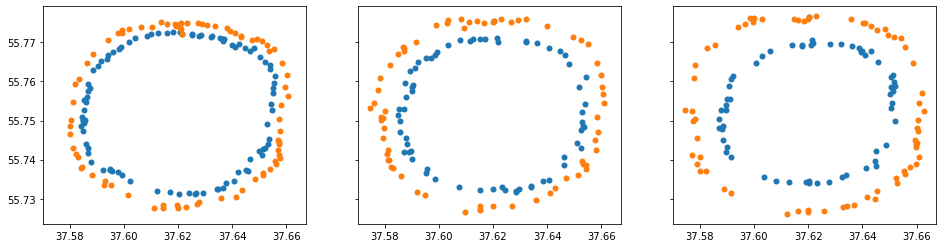

In [16]:
n_polygons = len(split_polygons)
figure, axes = plt.subplots(nrows=1, ncols=n_polygons, figsize=(16, 4), sharex=True, sharey=True)

for poly, ax in zip(split_polygons, axes):
    ax.scatter(poly[0][:, 0], poly[0][:, 1], linewidths=0.005)
    ax.scatter(poly[1][:, 0], poly[1][:, 1], linewidths=0.005)

plt.show()

In [17]:
house_coords = coords_db[["coor_x", "coor_y"]][coords_db[["coor_x", "coor_y"]]!=0].dropna().values

Уберём дома, которые точно вне полигонов:

In [18]:
def get_subhouses(houses, poly):
    x_min = np.min(poly[:, 0])
    x_max = np.max(poly[:, 0])
    y_min = np.min(poly[:, 1])
    y_max = np.max(poly[:, 1])
    
    a = houses[:, 0] > x_min
    b = np.logical_and(a, houses[:, 0] < x_max)
    c = np.logical_and(b, houses[:, 1] > y_min)
    d = np.logical_and(c, houses[:, 1] < y_max)

    return d

houses_mask = get_subhouses(coords_db[["coor_x", "coor_y"]].values, np.concatenate(polygons))

In [19]:
houses_mask.shape[0], houses_mask.sum()

(155526, 13434)

Осталось 12к домов

In [20]:
coords_sub_db = coords_db[houses_mask]
house_coords = coords_sub_db[["coor_x", "coor_y"]].values

In [21]:
import math
from PIL import Image

In [22]:
img = plt.imread('im0.jpeg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.

На глаз разделим внешние и внутренние точки полигона:

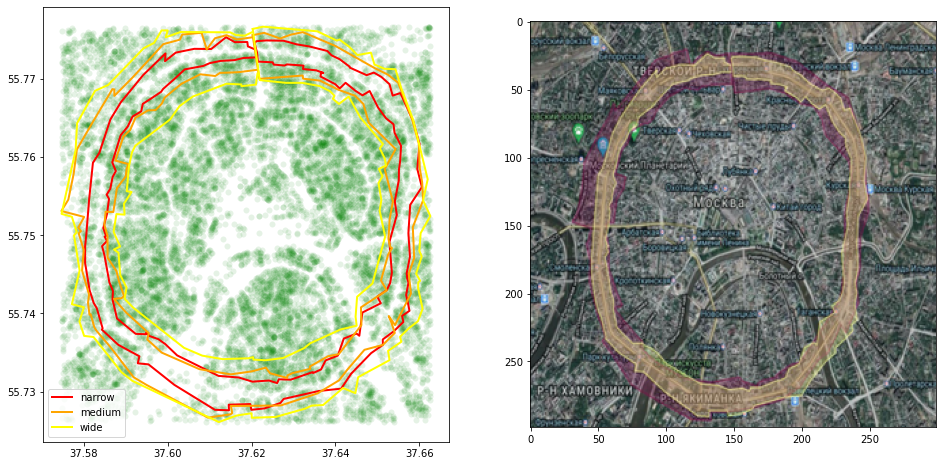

In [23]:
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

axes[0].scatter(house_coords[:, 0], house_coords[:, 1], linewidths=0.001, alpha=0.1, c="g")

for poly, name, c in zip(split_polygons, ["narrow", "medium", "wide"], ["red", "orange", "yellow"]):
    axes[0].plot(poly[0][:, 0], poly[0][:, 1], linewidth=2, label=name, color=c)
    axes[0].plot(poly[1][:, 0], poly[1][:, 1], linewidth=2, color=c)

axes[0].legend(loc="lower left")
axes[1].imshow(img)

plt.show()

Научимся различать точки внутри полигона (между синей и оранжевой линиями) от всех остальных:

In [24]:
def area(x1, y1, x2, y2, x3, y3): 
    return abs((x1 * (y2 - y3) + x2 * (y3 - y1)  
                + x3 * (y1 - y2)) / 2.0) 

def isInside(x1, y1, x2, y2, x3, y3, x, y): 
    ABC = area (x1, y1, x2, y2, x3, y3) 
    PBC = area (x, y, x2, y2, x3, y3)  
    PAC = area (x1, y1, x, y, x3, y3)
    PAB = area (x1, y1, x2, y2, x, y) 

    return np.isclose(ABC, PBC + PAC + PAB)

def point_inside_poly(poly, point):
    x_min = np.min(poly[:, 0])
    x_max = np.max(poly[:, 0])
    y_min = np.min(poly[:, 1])
    y_max = np.max(poly[:, 1])
    if point[0] < x_min or point[0] > x_max or point[1] < y_min or point[1] > y_max:
        return False
    
    center = poly.mean(axis=0)
    res = False
    for a, b in zip(poly, np.concatenate([poly[1:], poly[:1]])):
        res = res or isInside(*center, *a, *b, *point)
    return res

In [25]:
inside_polygon = []
for poly, name in zip(split_polygons, ["narrow", "medium", "wide"]):
    inside_inner = np.array([point_inside_poly(poly[0], h) for h in house_coords])
    inside_outer = np.array([point_inside_poly(poly[1], h) for h in house_coords])
    between = np.logical_xor(inside_inner, inside_outer)
    print("Houses in {} polygon: {}".format(name, np.sum(between)))
    inside_polygon.append(between)

Houses in narrow polygon: 1795
Houses in medium polygon: 3195
Houses in wide polygon: 5108


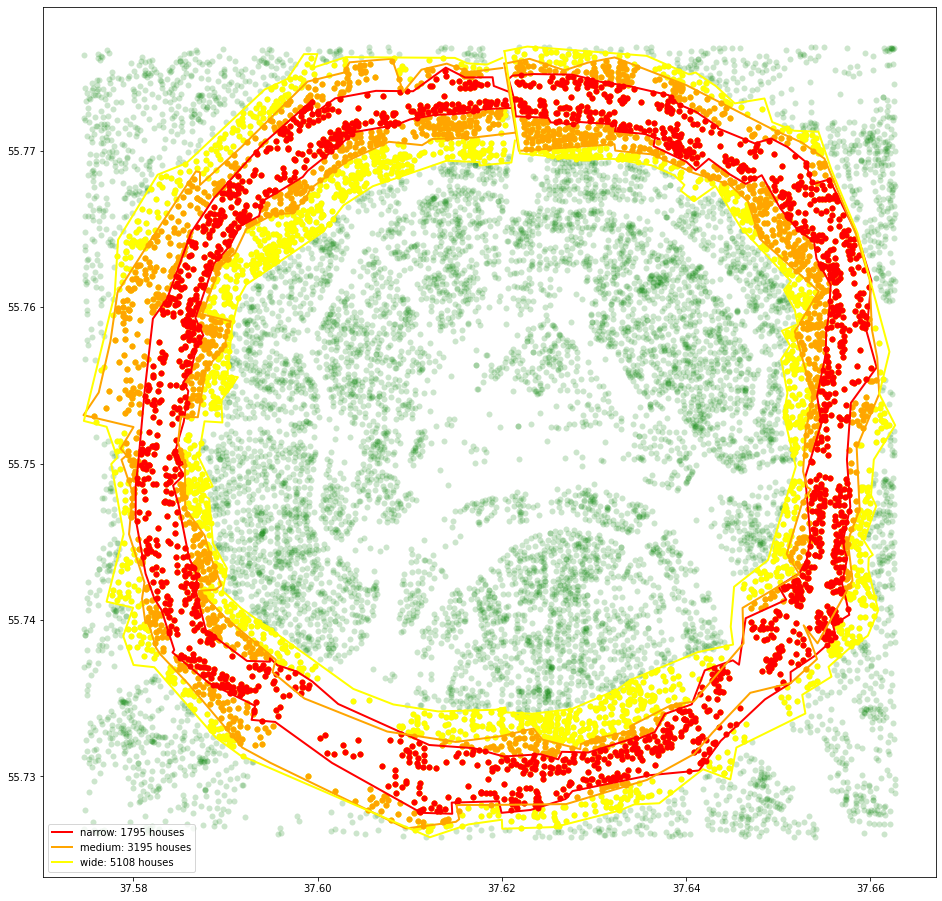

In [26]:
figure, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 16), sharex=True, sharey=True)


# axes.set_title("{} houses on garden ring".format(np.sum(between_polys)), size=32)


for poly, name, c, mark in zip(
        split_polygons, 
        ["narrow", "medium", "wide"],
        ["red", "orange", "yellow"],
        inside_polygon):
    axes.plot(poly[0][:, 0], poly[0][:, 1], linewidth=2, label="{}: {} houses".format(name, sum(mark)), color=c)
    axes.plot(poly[1][:, 0], poly[1][:, 1], linewidth=2, color=c)

axes.scatter(house_coords[:, 0], house_coords[:, 1], linewidths=0.0001, alpha=0.2, c="g")
axes.scatter(house_coords[inside_polygon[2], 0], house_coords[inside_polygon[2], 1], linewidths=0.0001, alpha=1, c="yellow")
axes.scatter(house_coords[inside_polygon[1], 0], house_coords[inside_polygon[1], 1], linewidths=0.0001, alpha=1, c="orange")
axes.scatter(house_coords[inside_polygon[0], 0], house_coords[inside_polygon[0], 1], linewidths=0.0001, alpha=1, c="red")

plt.legend(loc="lower left")

plt.show()

In [27]:
coords_sub_db["narrow"] = inside_polygon[0]
coords_sub_db["medium"] = inside_polygon[1]
coords_sub_db["wide"] = inside_polygon[2]

In [28]:
garden_ring_db = coords_sub_db[coords_sub_db["wide"]]

In [29]:
print(garden_ring_db.shape)
garden_ring_db.sample(10)

(5108, 6)


,address,coor_x,coor_y,narrow,medium,wide
165336,"город Москва, Смоленский бульвар, дом 24, стро...",37.586310,55.743391,True,True,True
43577,"город Москва, улица Спиридоновка, дом 36, стро...",37.589781,55.762787,False,False,True
43830,"город Москва, Житная улица, дом 10, строение 2",37.618964,55.730547,True,True,True
39510,"город Москва, Ермолаевский переулок, дом 3",37.589461,55.763735,True,True,True
56437,"город Москва, улица Гашека, дом 2, строение 2",37.589188,55.767698,False,True,True
3226,"город Москва, Татарская улица, дом 5, строение 5",37.639558,55.734147,True,True,True
77408,"город Москва, Садовая-Кудринская улица, владен...",37.588121,55.765402,True,True,True
123063,"город Москва, 1-я Брестская улица, дом 15",37.592336,55.770550,False,True,True
67793,"город Москва, Большой Козловский переулок, дом...",37.647878,55.766417,False,True,True
5238,"город Москва, Денежный переулок, дом 14/3",37.587834,55.743908,False,True,True


# Займёмся адресами:

Конвертируем всякие сокращения (используем те же сокращения, что и в таблице с портала mos.ru, импортируем её позже)

In [30]:
shortenings = [
    ("город", "г"),
    ("проспект", "пркт"),
    ("улица", "ул"),
    ("бульвар", "бр"),
    ("переулок", "пер"),
    ("проезд", "проезд"),
    ("шоссе", "ш"),
    ("площадь", "пл"),
    ("набережная", "наб"),
    ("дом", "д"),
    ("корпус", "к"),
    ("строение", "стр"),
    ("сооружение", "сооруж"),
    ("большой", "б"),
    ("большая", "б"),
    ("средний", "ср"),
    ("средняя", "ср"),
    ("малый", "м"),
    ("малая", "м")
]

In [31]:
def shorten_address(s, shrt=shortenings):
    x = s.lower()
    x = re.sub(r"[\.\,\-]", "", x)
    
    for a, b in shortenings:
        x = re.sub(a, b, x)
    x = re.sub(r"г москва", "", x)
    return x.strip()

def clip_bad_prefix(s, prefix="внутригская территория муниципальный округ"):
    if prefix in s:
        return " ".join(s.split()[len(prefix.split()) + 1:])

    return s

s = "внутригская территория муниципальный округ замоскворечье 6й монетчиковский пер д 12"
print(clip_bad_prefix(s))

6й монетчиковский пер д 12


In [32]:
garden_ring_db["short_address"] = garden_ring_db["address"].apply(shorten_address).apply(clip_bad_prefix)

In [33]:
garden_ring_db.sample(10)

,address,coor_x,coor_y,narrow,medium,wide,short_address
167538,"город Москва, Малый Казённый переулок, дом 2/1...",37.652932,55.760048,False,False,True,м казённый пер д 2/1 стр 3
128875,"город Москва, Зоологическая улица, дом 28, стр...",37.584805,55.766457,False,True,True,зоологическая ул д 28 стр 1
37178,"город Москва, Большой Казённый переулок, дом 8...",37.655459,55.759754,False,True,True,б казённый пер д 8 стр 4
28670,"город Москва, улица Крымский Вал, дом 9, строе...",37.603021,55.731553,True,True,True,ул крымский вал д 9 стр 9
168890,"город Москва, Большая Грузинская улица, дом 8,...",37.582455,55.760835,False,True,True,б грузинская ул д 8 стр 34
14264,"город Москва, Лялин переулок, дом 19, корпус 1",37.653191,55.758011,False,True,True,лялин пер д 19 к 1
96555,"город Москва, Денежный переулок, дом 7, корпус 2",37.587050,55.743592,False,True,True,денежный пер д 7 к 2
201174,"город Москва, Покровский бульвар, дом 11, стро...",37.651078,55.753912,False,False,True,покровский бр д 11 стр 5
119287,"город Москва, Садовая-Спасская улица, дом 13, ...",37.646442,55.770669,True,True,True,садоваяспасская ул д 13 стр 2
7885,"город Москва, улица Земляной Вал, дом 50А, стр...",37.653997,55.751666,False,True,True,ул земляной вал д 50а стр 6


Напишем небольшой парсер адресов:

In [34]:
s = "ул пречистенка д 40/2 стр 1"
def parse_address(s, prefixes=["д", "к", "стр", "сооруж"]):
    x = s.lower()
    x = re.sub(r"[\.\,\-]", "", x)
    x = re.sub(r"г москва", "", x)

    entities = {}
    for prefix in prefixes:
        pattern = re.compile(prefix + " " + "(\d*\w*/?\d*\w*)")
        finds = re.findall(pattern, x)
        if len(finds):
            entity = re.findall(pattern, x)[0]
            entities[prefix] = entity
            x = re.sub(prefix + " " + entity, "", x)
        x = re.sub(r"\W+", " ", x)

    return x.strip(), entities

def match_address(s, addresses):
    pattern = "(" + "|".join(addresses) + ")"
    return ",".join(re.findall(pattern, s))


def norm_address(x):
    return " ".join(sorted(x.split()))

print(parse_address(s))
print(norm_address(s))

('ул пречистенка', {'д': '40/2', 'стр': '1'})
1 40/2 д пречистенка стр ул


## Вычитываем табличку с описанием домов

In [35]:
house_descr_db = pd.read_csv("data/dump2.csv")

In [36]:
print(house_descr_db.shape)
house_descr_db.head()

(34433, 60)


,id,region_id,area_id,city_id,street_id,shortname_region,formalname_region,shortname_area,formalname_area,shortname_city,...,electrical_entries_count,heating_type,hot_water_type,cold_water_type,sewerage_type,sewerage_cesspools_volume,gas_type,ventilation_type,firefighting_type,drainage_type
0,8649748,0c5b2444-70a0-4932-980c-b4dc0d3f02b5,NaN,NaN,NaN,г,Москва,NaN,NaN,NaN,...,1.0,Центральное,Закрытая с приготовлением горячей воды на ЦТП,Центральное,Центральное,"0,00",Центральное,Вытяжная вентиляция,Отсутствует,Внутренние водостоки
1,9370109,0c5b2444-70a0-4932-980c-b4dc0d3f02b5,NaN,NaN,NaN,г,Москва,NaN,NaN,NaN,...,NaN,Не заполнено,Не заполнено,Не заполнено,Не заполнено,NaN,Не заполнено,Не заполнено,Не заполнено,Не заполнено
2,8963246,0c5b2444-70a0-4932-980c-b4dc0d3f02b5,NaN,NaN,NaN,г,Москва,NaN,NaN,NaN,...,7.0,Центральное,Закрытая с приготовлением горячей воды на ЦТП,Центральное,Центральное,NaN,Отсутствует,Приточно-вытяжная вентиляция,Пожарные гидранты,Внутренние водостоки
3,8932138,0c5b2444-70a0-4932-980c-b4dc0d3f02b5,NaN,NaN,NaN,г,Москва,NaN,NaN,NaN,...,NaN,Не заполнено,Не заполнено,Не заполнено,Не заполнено,NaN,Не заполнено,Не заполнено,Не заполнено,Не заполнено
4,8932139,0c5b2444-70a0-4932-980c-b4dc0d3f02b5,NaN,NaN,NaN,г,Москва,NaN,NaN,NaN,...,NaN,Не заполнено,Не заполнено,Не заполнено,Не заполнено,NaN,Не заполнено,Не заполнено,Не заполнено,Не заполнено


Оставляем только интересные нам столбцы. Можно посмотреть, сколько в них пропусков (в каждом столбце):

In [37]:
useful_columns = [
    "address",
    "house_number",
    "building",
    "block",
    "letter",
    "floor_count_max",
    "floor_count_min",
    "entrance_count",
    "quarters_count",
    "living_quarters_count",
    "unliving_quarters_count" 
]

In [38]:
house_descr_db = house_descr_db[useful_columns]

In [39]:
house_descr_db.isnull().sum(axis = 0)

address                        0
house_number                 470
building                   32706
block                      18326
letter                     34417
floor_count_max              304
floor_count_min             1589
entrance_count               339
quarters_count                 0
living_quarters_count       1552
unliving_quarters_count     1942
dtype: int64

Проделываем ту же процедуру сокращения адресов:

In [40]:
house_descr_db["short_address"] = house_descr_db["address"].apply(shorten_address).apply(clip_bad_prefix)

In [41]:
print(house_descr_db.shape)
house_descr_db.head()

(34433, 12)


,address,house_number,building,block,letter,floor_count_max,floor_count_min,entrance_count,quarters_count,living_quarters_count,unliving_quarters_count,short_address
0,"г. Москва, д. 9, к. 1",9,NaN,1,NaN,9.0,9.0,4.0,144,144.0,0.0,д 9 к 1
1,"г. Москва, д. 14, к. 1",14,NaN,1,NaN,NaN,NaN,NaN,0,NaN,NaN,д 14 к 1
2,"г. Москва, д. 42, к. 2",42,NaN,2,NaN,17.0,17.0,7.0,476,474.0,2.0,д 42 к 2
3,"г. Москва, д. 2301",2301,NaN,NaN,NaN,13.0,NaN,6.0,0,NaN,NaN,д 2301
4,"г. Москва, д. 2302",2302,NaN,NaN,NaN,11.0,9.0,3.0,0,NaN,NaN,д 2302


Создадим сущность `norm_address`, в котором слова из `short address` расположены в алфавитном порядке:

In [42]:
garden_ring_db["norm_address"] = garden_ring_db.short_address.apply(norm_address)
house_descr_db["norm_address"] = house_descr_db.short_address.apply(norm_address)

In [43]:
joined_db = pd.merge(
    garden_ring_db,
    house_descr_db,
    how="left",
    on="norm_address"
)

In [44]:
joined_db

,address_x,coor_x,coor_y,narrow,medium,wide,short_address_x,norm_address,address_y,house_number,building,block,letter,floor_count_max,floor_count_min,entrance_count,quarters_count,living_quarters_count,unliving_quarters_count,short_address_y
0,"город Москва, улица Спиридоновка, дом 21",37.590096,55.762021,False,False,True,ул спиридоновка д 21,21 д спиридоновка ул,"г. Москва, ул. Спиридоновка, д. 21",21,NaN,NaN,NaN,5.0,5.0,1.0,29.0,29.0,0.0,ул спиридоновка д 21
1,"город Москва, 5-й Монетчиковский переулок, дом 16",37.630541,55.732349,False,True,True,5й монетчиковский пер д 16,16 5й д монетчиковский пер,"г. Москва, пер. Монетчиковский 5-й, д. 16",16,NaN,NaN,NaN,3.0,0.0,2.0,6.0,3.0,3.0,пер монетчиковский 5й д 16
2,"город Москва, улица Тимура Фрунзе, дом 28",37.586975,55.736270,False,True,True,ул тимура фрунзе д 28,28 д тимура ул фрунзе,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"город Москва, улица Гашека, дом 9",37.590192,55.769251,False,True,True,ул гашека д 9,9 гашека д ул,"г. Москва, ул. Гашека, д. 9",9,NaN,NaN,NaN,5.0,1.0,5.0,45.0,40.0,5.0,ул гашека д 9
4,"город Москва, Товарищеский переулок, дом 1, ст...",37.657778,55.741372,False,False,True,товарищеский пер д 1 стр 1,1 1 д пер стр товарищеский,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5103,"город Москва, внутригородская территория муниц...",37.649902,55.735630,True,False,True,краснохолмская наб д 1а,1а д краснохолмская наб,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5104,"город Москва, внутригородская территория муниц...",37.587469,55.748586,False,False,True,ул арбат д 40 стр 3,3 40 арбат д стр ул,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5105,"город Москва, 2-й Новокузнецкий переулок, дом ...",37.631924,55.734357,False,False,True,2й новокузнецкий пер д 10 стр б/н,10 2й б/н д новокузнецкий пер стр,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5106,"город Москва, внутригородская территория муниц...",37.639233,55.734226,True,True,True,татарская ул земельный участок 5/5,5/5 земельный татарская ул участок,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
shorts_garden = set(garden_ring_db["short_address"].values)
norms_garden = set(garden_ring_db["norm_address"].values)

shorts_descr = set(house_descr_db["short_address"].values) 
norms_descr = set(house_descr_db["norm_address"].values) 

Посмотрим, сколько адресов из таблицы с координатами нашлось:

In [46]:
shorts_intersect =  [x for x in shorts_garden if x in shorts_descr]
norms_intersect = [x for x in norms_garden if x in norms_descr]
len(shorts_intersect), len(norms_intersect)

(194, 919)

Нашлось 306 домов. Посмотрим, какие не нашлись.

In [47]:
def address_lookup(series, s):
    return series[series.str.contains(s)]

In [48]:
lost_norms_addresses = [x for x in norms_garden if x not in norms_descr]

Посмотрим, какие там самые частые слова

In [49]:
from collections import Counter
from nltk.tokenize import WhitespaceTokenizer

In [50]:
c = Counter()
c_alpha = Counter()
tokenizer = WhitespaceTokenizer()

for adr in lost_norms_addresses:
    c.update([x for x in tokenizer.tokenize(adr) if len(x) > 4])

In [51]:
c.most_common(15)

[('владение', 211),
 ('земляной', 132),
 ('каретный', 86),
 ('садоваякудринская', 78),
 ('грузинская', 68),
 ('сооруж', 64),
 ('казённый', 62),
 ('смоленский', 61),
 ('садовая', 57),
 ('ордынка', 57),
 ('тупик', 56),
 ('николоямская', 55),
 ('тимура', 54),
 ('фрунзе', 54),
 ('цветной', 54)]

Пойдём разбираться, что там с названиями улиц:

In [52]:
print(np.random.choice(address_lookup(pd.Series(lost_norms_addresses), "земляной"), 25))

['41 б/н вал д земляной стр ул' '2 30 вал д земляной стр ул'
 '2 61 вал д земляной стр ул' '57/6 вал з/у земляной ул'
 '24/32 7 вал владение земляной стр ул' '24/32 7 вал д земляной стр ул'
 '21 53 вал д земляной стр ул' '10 32 вал д земляной стр ул'
 '14/16 2 вал д земляной стр ул' '59 вал д земляной ул'
 '2 53 вал д земляной стр ул' '12/7 4 вал д земляной стр ул'
 '57/6 вал з/у земляной ул' '16 53 вал д земляной стр ул'
 '17 53 вал д земляной стр ул' '2 41/2 вал д земляной стр ул'
 '1 30 вал д земляной стр ул' '11 29 вал д земляной стр ул'
 '57/6 вал з/у земляной ул' '57а вал д земляной ул'
 '2 53 вал д земляной стр ул' '2 53 вал д земляной стр ул'
 '34 3б/н вал д земляной стр ул' '9 вал д земляной ул'
 '2 54 вал д земляной стр ул']


In [53]:
print(np.random.choice(address_lookup(house_descr_db["short_address"], "земляной"), 25))

['ул земляной вал д 34 стр 3а' 'ул земляной вал д 42/20'
 'ул земляной вал д 21/2 стр 1' 'ул земляной вал д 52/16 стр 3'
 'ул земляной вал д 48б' 'ул земляной вал д 1/4 стр 1'
 'ул земляной вал д 1822 стр 2' 'ул земляной вал д 42/20'
 'ул земляной вал д 32' 'ул земляной вал д 46' 'ул земляной вал д 48б'
 'ул земляной вал д 48б' 'ул земляной вал д 24/30 стр 1'
 'ул земляной вал д 21/2 стр 1' 'ул земляной вал д 1/4 стр 2'
 'ул земляной вал д 34 стр 4' 'ул земляной вал д 46'
 'ул земляной вал д 21/24 стр 2' 'ул земляной вал д 24/32'
 'ул земляной вал д 1822 стр 1' 'ул земляной вал д 27 стр 2'
 'ул земляной вал д 10' 'ул земляной вал д 48а' 'ул земляной вал д 48б'
 'ул земляной вал д 10']


In [54]:
print(np.random.choice(address_lookup(garden_ring_db["short_address"], "земляной"), 25))

['ул земляной вал д 44а стр 1' 'ул земляной вал д 48а стр 9'
 'ул земляной вал д 39/1 стр 1' 'ул земляной вал д 64 стр 5'
 'ул земляной вал д 54 стр 1' 'ул земляной вал д 3840 стр 5'
 'ул земляной вал владение 24/32 стр 7' 'ул земляной вал д 27 стр 5'
 'ул земляной вал д 52 стр 4' 'ул земляной вал д 36 стр 4'
 'ул земляной вал д 7 стр 1' 'ул земляной вал д 30 стр 1'
 'ул земляной вал д 41 стр б/н' 'ул земляной вал д 27 стр 3'
 'ул земляной вал д 1/4 стр 15' 'ул земляной вал д 46'
 'ул земляной вал д 30 стр 1' 'ул земляной вал д 18 стр 4'
 'ул земляной вал д 21/24 стр 3' 'ул земляной вал д 1/4 стр 14'
 'ул земляной вал владение 24/32 стр 7' 'ул земляной вал д 12/7 стр 1'
 'ул земляной вал д 41/2 стр 2' 'ул земляной вал д 29 стр 13'
 'ул земляной вал д 4 стр 1']


Выглядит так, что правда многих домов нет в базе с мос.ру.

Соберём статистику по тем, что есть:

In [55]:
garden_house_desr = house_descr_db[house_descr_db["norm_address"].isin(norms_garden)]

In [56]:
# # for_stats = garden_house_desr
# #for_stats.loc[:, "groupby"] = "total"
# for_stats.groupby("groupby").agg(
#     {
#          "address": ["count"],
#          "living_quarters_count":["mean",  "sum"],
#          "quarters_count" : ["sum"],
#          "entrance_count": ["mean",  "sum"],
#          "floor_count_min": ["min", "mean", "max"],
#          "floor_count_max": ["min", "mean", "max"],
#     })

In [57]:
joined_db.groupby(["narrow", "medium", "wide"], as_index=False).agg(
    {
         "address_y": ["count"],
         "living_quarters_count":["mean",  "sum"],
         "quarters_count" : ["sum"],
         "entrance_count": ["mean",  "sum"],
         "floor_count_min": ["min", "mean", "max"],
         "floor_count_max": ["min", "mean", "max"],
    })

narrow medium  wide address_y living_quarters_count          quarters_count  \
                          count                  mean      sum            sum   
0  False  False  True       350             44.443787  15022.0        17062.0   
1  False   True  True       266             40.879377  10506.0        11078.0   
2   True  False  True         1              8.000000      8.0            8.0   
3   True   True  True       304             55.962329  16341.0        18216.0   

  entrance_count        floor_count_min                 floor_count_max  \
            mean    sum             min      mean   max             min   
0       2.210983  765.0             0.0  5.008824  25.0             0.0   
1       2.125475  559.0             0.0  5.613281  24.0             0.0   
2       1.000000    1.0             0.0  0.000000   0.0             4.0   
3       2.922819  871.0             0.0  5.236301  17.0             2.0   

                   
       mean   max  
0  6.615607  25.0  
1  6.562738  31.0  
2  4.000000   4.0  
3  6.848993  26.0